In [1]:
import os
import sys
import gc
# assuming data, models, engine in flicc directory:
flicc_path = os.path.realpath("__file__").split('grid_search')[0]
sys.path.append(flicc_path)
import torch
from data import ClimateDataset
from models import ClassificationModel
from engine import Engine

In [2]:
model_checkpoint='microsoft/deberta-base'

In [3]:
results = {'test_acc':[],
           'test_f1':[],
           'eval_acc':[],
           'eval_f1':[],
           'wd':[]}

In [4]:
g = 4
lr = 1.0e-5
weight_decay = [0.1, 0.01]

for wd in weight_decay:
    print(f'Grid search {model_checkpoint}, learning rate {lr}, focal loss gamma {g}, weight decay {wd}')
    data = ClimateDataset(model_to_train=1,model_checkpoint=model_checkpoint,dataset_url=flicc_path,batch_size=32)
    data.setup_dataloaders()
    model = ClassificationModel(model_checkpoint=data.model_checkpoint,num_labels=data.num_labels)
    trainer = Engine(epochs=30,labels=data.labels)
    trainer.model = model.model
    trainer.dataset_encoded = data.dataset_encoded
    test_acc, test_f1, eval_acc, eval_f1 = trainer.run(lr=lr,
                                                       wd=wd,
                                                       train_dataloader=data.train_dataloader,
                                                       eval_dataloader=data.eval_dataloader,
                                                       test_dataloader=data.test_dataloader,
                                                       focalloss=True,
                                                       gamma=g,
                                                       early_stop=3)
    results['test_acc'].append(test_acc)
    results['test_f1'].append(test_f1)
    results['eval_acc'].append(eval_acc)
    results['eval_f1'].append(eval_f1)
    results['wd'].append(wd)
    print('### '*10)
    print(results)
    print('### '*10)
    with torch.no_grad():
        torch.cuda.empty_cache()
    del data, model, trainer, test_acc, test_f1, eval_acc, eval_f1
    gc.collect()

Grid search microsoft/deberta-base, learning rate 1e-05, focal loss gamma 4, weight decay 0.1


Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.bias', 'classifier.weight', 'pooler.dense.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DebertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


1 / 30: Train Loss:	0.0873	Val Loss:	0.7006	Accuracy:	0.2691	F1:	0.2197
2 / 30: Train Loss:	0.0834	Val Loss:	0.6771	Accuracy:	0.7834	F1:	0.6724
3 / 30: Train Loss:	0.0760	Val Loss:	0.6419	Accuracy:	0.7484	F1:	0.7142
4 / 30: Train Loss:	0.0638	Val Loss:	0.6652	Accuracy:	0.5230	F1:	0.5220
5 / 30: Train Loss:	0.0576	Val Loss:	0.5410	Accuracy:	0.7899	F1:	0.7455
6 / 30: Train Loss:	0.0464	Val Loss:	0.4978	Accuracy:	0.8425	F1:	0.7831
7 / 30: Train Loss:	0.0377	Val Loss:	0.4699	Accuracy:	0.7987	F1:	0.7612
8 / 30: Train Loss:	0.0259	Val Loss:	0.5469	Accuracy:	0.7024	F1:	0.6845
9 / 30: Train Loss:	0.0229	Val Loss:	0.4682	Accuracy:	0.7856	F1:	0.7516
No improvement for 3 epochs. Stopping early.
best (higgest macro f1-score) val results:
              precision    recall  f1-score   support

       bknow       0.74      0.61      0.67       119
      struct       0.87      0.92      0.90       338

    accuracy                           0.84       457
   macro avg       0.80      0.77      0.78   

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.bias', 'classifier.weight', 'pooler.dense.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DebertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


1 / 30: Train Loss:	0.0873	Val Loss:	0.7005	Accuracy:	0.2691	F1:	0.2197
2 / 30: Train Loss:	0.0811	Val Loss:	0.6576	Accuracy:	0.7068	F1:	0.6847
3 / 30: Train Loss:	0.0750	Val Loss:	0.6561	Accuracy:	0.7593	F1:	0.7168
4 / 30: Train Loss:	0.0701	Val Loss:	0.6289	Accuracy:	0.7921	F1:	0.7232
5 / 30: Train Loss:	0.0607	Val Loss:	0.6246	Accuracy:	0.8031	F1:	0.7624
6 / 30: Train Loss:	0.0543	Val Loss:	0.5890	Accuracy:	0.7068	F1:	0.6884
7 / 30: Train Loss:	0.0397	Val Loss:	0.5130	Accuracy:	0.7724	F1:	0.7428
8 / 30: Train Loss:	0.0326	Val Loss:	0.5219	Accuracy:	0.7046	F1:	0.6843
No improvement for 3 epochs. Stopping early.
best (higgest macro f1-score) val results:
              precision    recall  f1-score   support

       bknow       0.60      0.75      0.66       119
      struct       0.90      0.82      0.86       338

    accuracy                           0.80       457
   macro avg       0.75      0.79      0.76       457
weighted avg       0.82      0.80      0.81       457

test resu

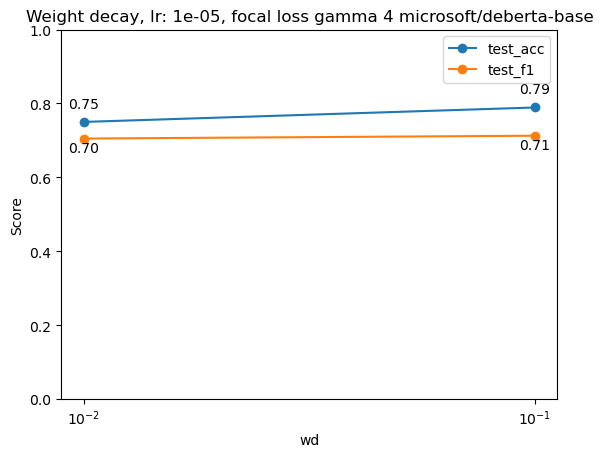

In [5]:
Engine.plot_grid_search(df=results,
                        title=f'Weight decay, lr: {lr}, focal loss gamma {g} {model_checkpoint}',
                        column='wd',
                        sci_format=True)

In [6]:
%reset -f